# Домашнее задание №1

В этом домашнем задании вам предлагается обучить модель регрессии для предсказания стоимости автомобилей, а также реализовать веб-сервис для применения построенной модели на новых данных.

> Оценка за домашку = min(ваш балл, 10)


Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода.

А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from dataclasses import dataclass #because why not
import math
import re
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE, make_scorer
from sklearn.linear_model import RidgeCV


random.seed(42)
np.random.seed(42)

In [2]:
@dataclass
class LinregAndEda:
    def remove_units(self: object, val: object):        
        #if we have empty value("") insert NaN for feature work with values
        try:
            return np.NaN if not str(val).split(' ')[0] else float(str(val).split(' ')[0])
        except:
            print(f'Problem with {val}')

    def process_units_torque(self: object, val: object):
        if isinstance(val, str) or not math.isnan(val):
            units = ['( )', 'rpm', 'nm@', '(kgm@ rpm)', 'kgm at', "@", 'nm', 'nm at', 'kgm', '/', 'at', '//', '(', ')']
            
            pattern = '|'.join(map(re.escape, units))
            #print(f'----------------------{val}::{type(val)}')
            # Заменить найденные значения на пустую строку
            return re.sub(pattern, '', val.lower())
        
    def create_max_torque(self: object, val: object):
        try:
            if val is not None and isinstance(val, str):
                elements_to_split = ['-', '~', '+-']
                max_torque = val.split(' ')[1]
                if any(el in max_torque for el in elements_to_split):
                    split_pattern = '|'.join(map(re.escape, elements_to_split))
                    max_torque = re.split(split_pattern, max_torque)[1]
                return np.nan if max_torque == "" else float(max_torque.replace(',', '')) 
        except Exception as e:
            print(f'problem wth {val} || {e}')
            return np.nan
        
    def process_torque(self: object, val: object):
        try:
            if val is not None and isinstance(val, str):           
                torque = val.split(' ')[0]
                torque = torque.split('(')[0]            
                return np.nan if torque == "" else float(torque)
        except Exception as e:
            print(f'problem wth {val} || {e}')
            return np.nan
        
    def show_metrics(self, model, data, answer):        
        print(f'R2 score for {model.__class__}: {r2_score(answer, model.predict(data))}')
        print(f'MSE score for {model.__class__}: {MSE(answer, model.predict(data))}')



In [3]:
linregAndEda = LinregAndEda()

Ниже ответьте на вопрос <font color='#FF6600'>
"Для чего фиксируем сиды в домашках?"</font>

In [4]:
print("Для повторяемости полученных результатов/эксперементов")

Для повторяемости полученных результатов/эксперементов


# Часть 1 (2.5 балла + 0.75) | EDA

## Простейший EDA и обработка признаков (1.5 балла + 0.25)

In [5]:
df_train = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/hse-mlds/ml/main/hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


(0.15 балла) <font color='#9933CC'>Отобразите 10 **случайных** строк тренировочного датасета</font>

In [6]:
df_train.sample(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6565,Renault KWID Climber 1.0 MT BSIV,2019,300000,35000,Petrol,Individual,Manual,First Owner,23.01 kmpl,999 CC,67 bhp,91Nm@ 4250rpm,5.0
2943,Maruti Wagon R LXI,2013,225000,58343,Petrol,Trustmark Dealer,Manual,First Owner,21.79 kmpl,998 CC,67.05 bhp,90Nm@ 3500rpm,5.0
2024,Hyundai i20 Asta 1.2,2013,360000,30000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
263,Hyundai i20 1.2 Asta,2010,300000,70000,Petrol,Individual,Manual,First Owner,17.0 kmpl,1197 CC,80 bhp,"11.4 kgm at 4,000 rpm",5.0
4586,Skoda Octavia L and K 1.9 TDI MT,2005,250000,120000,Diesel,Individual,Manual,Third Owner,16.4 kmpl,1896 CC,90 bhp,"21.4@ 1,900(kgm@ rpm)",5.0
4479,Maruti Ciaz ZXi,2016,700000,20000,Petrol,Individual,Manual,First Owner,20.73 kmpl,1373 CC,91.1 bhp,130Nm@ 4000rpm,5.0
4881,Hyundai Grand i10 1.2 Kappa Magna BSIV,2017,445000,27000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
3583,Ford Ecosport 1.5 DV5 MT Trend,2016,515000,68609,Diesel,Dealer,Manual,First Owner,22.7 kmpl,1498 CC,89.84 bhp,204Nm@ 2000-2750rpm,5.0
6361,Hyundai Verna 1.4 VTVT,2014,500000,33400,Petrol,Individual,Manual,First Owner,17.43 kmpl,1396 CC,105.5 bhp,135.3Nm@ 5000rpm,5.0
4108,Hyundai i20 Era 1.2,2015,490000,45900,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0


(0.1 балла) <font color='#9933CC'>Отобразите первые 5 и последние 5 объектов тестового датасета</font>

In [7]:
#pd.concat([df_test.head(), df_test.tail(5)])
df_test

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81 kmpl,1086 CC,68.05 bhp,99.04Nm@ 4500rpm,5.0
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36 kmpl,1197 CC,78.9 bhp,111.8Nm@ 4000rpm,5.0


(0.1 балла) <font color='#9933CC'>Посчитайте основные статистики как по числовым, так и по категориальным столбцам для трейна и теста</font>. 
> Подсказка: ``.describe()`` с нужным(и) аргументом(-ами)



In [8]:
print(df_train.describe())
print("------------")
print(df_train.describe(include='object'))

              year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000
------------
                          name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power 

In [9]:
print(df_test.describe())
print("------------")
print(df_test.describe(include='object'))

              year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000
------------
                       name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque

(0.15 балла) <font color='#9933CC'>Посмотрите, есть ли в датасете пропуски.</font>

<font color='#FF6600'>Если есть, то в каких колонках?</font>

In [10]:
columns_with_missing_values = df_train.columns[df_train.isnull().any()]
columns_with_missing_values.append(df_test.columns[df_test.isnull().any()])
columns_with_missing_values

Index(['mileage', 'engine', 'max_power', 'torque', 'seats'], dtype='object')

(0.1 балла) <font color='#9933CC'>Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием</font> (целевую переменную следует исключить). Если есть, то сколько?

In [11]:
df_train.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
6994    False
6995    False
6996    False
6997     True
6998     True
Length: 6999, dtype: bool

In [12]:
duplicates = df_train[df_train.drop(['selling_price'], axis=1).duplicated()]
len(duplicates)

1159

(0.15 балла) <font color='#9933CC'>Отобразите такие объекты</font>

In [13]:
duplicates

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
254,Hyundai Grand i10 Sportz,2017,450000,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0
258,Maruti Swift VXI,2012,330000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0
268,Maruti Swift Dzire VXI,2014,400000,70000,Petrol,Individual,Manual,Second Owner,19.1 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0
324,Jaguar XE 2016-2019 2.0L Diesel Prestige,2017,2625000,9000,Diesel,Dealer,Automatic,First Owner,13.6 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0
325,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6947,Chevrolet Spark 1.0 LS,2010,140000,60000,Petrol,Individual,Manual,Second Owner,18.0 kmpl,995 CC,62 bhp,90.3Nm@ 4200rpm,5.0
6984,Ford Freestyle Titanium Plus Diesel BSIV,2018,746000,24000,Diesel,Individual,Manual,First Owner,24.4 kmpl,1498 CC,98.63 bhp,215Nm@ 1750-3000rpm,5.0
6989,Maruti Swift Dzire VDI,2015,625000,50000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


(0.15 балла) <font color='#9933CC'>Удалите повторяющиеся строки</font>. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю

In [14]:
columns = list(df_train.columns)
columns.remove('selling_price')
columns

['name',
 'year',
 'km_driven',
 'fuel',
 'seller_type',
 'transmission',
 'owner',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats']

In [15]:
df_train = df_train.drop_duplicates(subset=columns, keep='first')
df_train.shape

(5840, 13)

In [16]:
assert df_train.shape == (5840, 13)

(0.1 балла) Чтоб все было по красоте, <font color='#9933CC'>обновите индексы строк таким образом, чтобы они шли от 0 без пропусков</font>

In [17]:
df_train = df_train.reset_index(drop=True)

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не слава богу. Давайте починим.

(0.25 балла) Задача такая: 
<font color='#9933CC'>
* убрать единицы измерения для признаков ``mileage, engine, max_power``. 
* кастануть эти столбцы столбцы к ``float``.
* удалить столбец ``torque``
</font>

> Все действия нужно производить над обоими датасетами

---
**Доп (0.25 балла):**
* <font color='#9933CC'>Вместо удаления признак `torque` разделите на два: собственно `torque` и `max_torque_rpm`.</font> Учтите единицы измерения. Они разные ☹

In [18]:
# 1. Work with mileage column
df_train['mileage'] = df_train['mileage'].apply(linregAndEda.remove_units)
df_test['mileage'] = df_train['mileage'].apply(linregAndEda.remove_units)

In [19]:
# 2. Work with engine column
df_train['engine'] = df_train['engine'].apply(linregAndEda.remove_units)
df_test['engine'] = df_test['engine'].apply(linregAndEda.remove_units)

In [20]:
# 3. Work with engine column.
df_train['max_power'] = df_train['max_power'].apply(linregAndEda.remove_units)
df_test['max_power'] = df_test['max_power'].apply(linregAndEda.remove_units)

In [21]:
# 4. Work with torque column
# remove units
df_train['torque'] = df_train['torque'].apply(linregAndEda.process_units_torque)
df_test['torque'] = df_test['torque'].apply(linregAndEda.process_units_torque)

# create max_torque column/feature
df_train['max_torque'] = df_train['torque'].apply(linregAndEda.create_max_torque)
df_test['max_torque'] = df_test['torque'].apply(linregAndEda.create_max_torque)

# process torque column/feature
df_train['torque'] = df_train['torque'].apply(linregAndEda.process_torque)
df_test['torque'] = df_test['torque'].apply(linregAndEda.process_torque)


problem wth 400 || list index out of range
problem wth 400 || list index out of range
problem wth 400 || list index out of range
problem wth 400 || list index out of range
problem wth 400 || list index out of range
problem wth 400 || list index out of range
problem wth 480 || list index out of range


In [22]:
df_train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190.00,5.0,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250.00,5.0,2500.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.40,5.0,NaN
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,11.50,5.0,4500.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.75,5.0,4000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086.0,62.10,96.10,5.0,3000.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998.0,67.10,90.00,5.0,3500.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,113.70,5.0,4000.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110.00,24.00,5.0,2750.0


(0.15 балла) <font color='#9933CC'>Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось</font>

> Обратите внимание, что, по уму, нужно посчитать медиану по трейну и этим средним заполнять пропуски в тесте. Так же делаем, если, например, стандартизируем признаки.



In [23]:
numerical_columns_train = df_train.select_dtypes(include=["number"])


medians_train = numerical_columns_train.median()

df_train[numerical_columns_train.columns] = df_train[
    numerical_columns_train.columns
].fillna(medians_train)
df_test[numerical_columns_train.columns] = df_test[
    numerical_columns_train.columns
].fillna(medians_train)

In [24]:
print(df_train.describe())

              year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power        torque        seats    max_torque  
count  5840.000000   5840.000000  5840.000000   5840.000000  
mean     87.906371    167.757978     5.426712   3048.152055  
std      31.640418    503.956633     0.982344    896.147936  
min       0.000000      4.800000     2.000000    500.00000

In [25]:
print(df_test.describe())

              year  selling_price      km_driven      mileage      engine  \
count  1000.000000   1.000000e+03    1000.000000  1000.000000  1000.00000   
mean   2013.681000   6.179010e+05   71393.341000    19.303840  1454.87600   
std       4.012149   7.585539e+05   48486.218662     4.033975   521.99574   
min    1995.000000   3.100000e+04    1303.000000     0.000000   624.00000   
25%    2011.000000   2.500000e+05   37000.000000    16.800000  1197.00000   
50%    2014.000000   4.349990e+05   61500.000000    19.315000  1248.00000   
75%    2017.000000   6.700000e+05  100000.000000    22.000000  1582.00000   
max    2020.000000   6.000000e+06  375000.000000    42.000000  3604.00000   

         max_power        torque        seats   max_torque  
count  1000.000000   1000.000000  1000.000000  1000.000000  
mean     90.841670    176.612210     5.403000  3099.426000  
std      34.893389    355.910712     0.912921   867.265805  
min      34.200000      6.100000     4.000000   500.000000  
2


(0.1 балла) Теперь, когда не осталось пропусков, можно <font color='#9933CC'>преобразовать столбцы к более подходящим типам (``engnine`` и ``seats`` к int)
</font>

Ниже ответьте, <font color='#FF6600'>почему (хоть мы этого и не делаем) ``seats``, возможно, лучше сделать переменной категориальной, а не целочисленной.</font>

In [26]:
print("""
Потому что количество сидений может влиять на категорию автомобиля - седан, автобус, семейный, спортивный тд.
Более естественно - количество сидений ограниченно набором значений.""")


Потому что количество сидений может влиять на категорию автомобиля - седан, автобус, семейный, спортивный тд.
Более естественно - количество сидений ограниченно набором значений.


In [27]:
df_train['engine'] = df_train['engine'].apply(lambda val: int(val))
df_train['seats'] = df_train['seats'].apply(lambda val: int(val))

df_test['engine'] = df_test['engine'].apply(lambda val: int(val))
df_test['seats'] = df_test['seats'].apply(lambda val: int(val))

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           5840 non-null   object 
 1   year           5840 non-null   int64  
 2   selling_price  5840 non-null   int64  
 3   km_driven      5840 non-null   int64  
 4   fuel           5840 non-null   object 
 5   seller_type    5840 non-null   object 
 6   transmission   5840 non-null   object 
 7   owner          5840 non-null   object 
 8   mileage        5840 non-null   float64
 9   engine         5840 non-null   int64  
 10  max_power      5840 non-null   float64
 11  torque         5840 non-null   float64
 12  seats          5840 non-null   int64  
 13  max_torque     5840 non-null   float64
dtypes: float64(4), int64(5), object(5)
memory usage: 638.9+ KB


## Визуализации (1 балл + 0.5)

Визуализировать нам надо не так уж и много. Во-первых, хотелось бы, в принципе, увидеть как распределены значения признаков. Также хотелось бы понять, насколько признаки скоррелированы между собой и с целевой переменной. А ещё неплохо бы посмотреть, не оказалось ли так, что тестовые данные распределены иначе, чем трейн.

Этим всем и предлагаем вам заняться.

(0.25 балла) <font color='#9933CC'>Посторойте попарные распределения всех числовых признаков для трейна.</font>

> ``sns.paiplot()`` позволяет сделать это в одну строчку

/home/roman/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


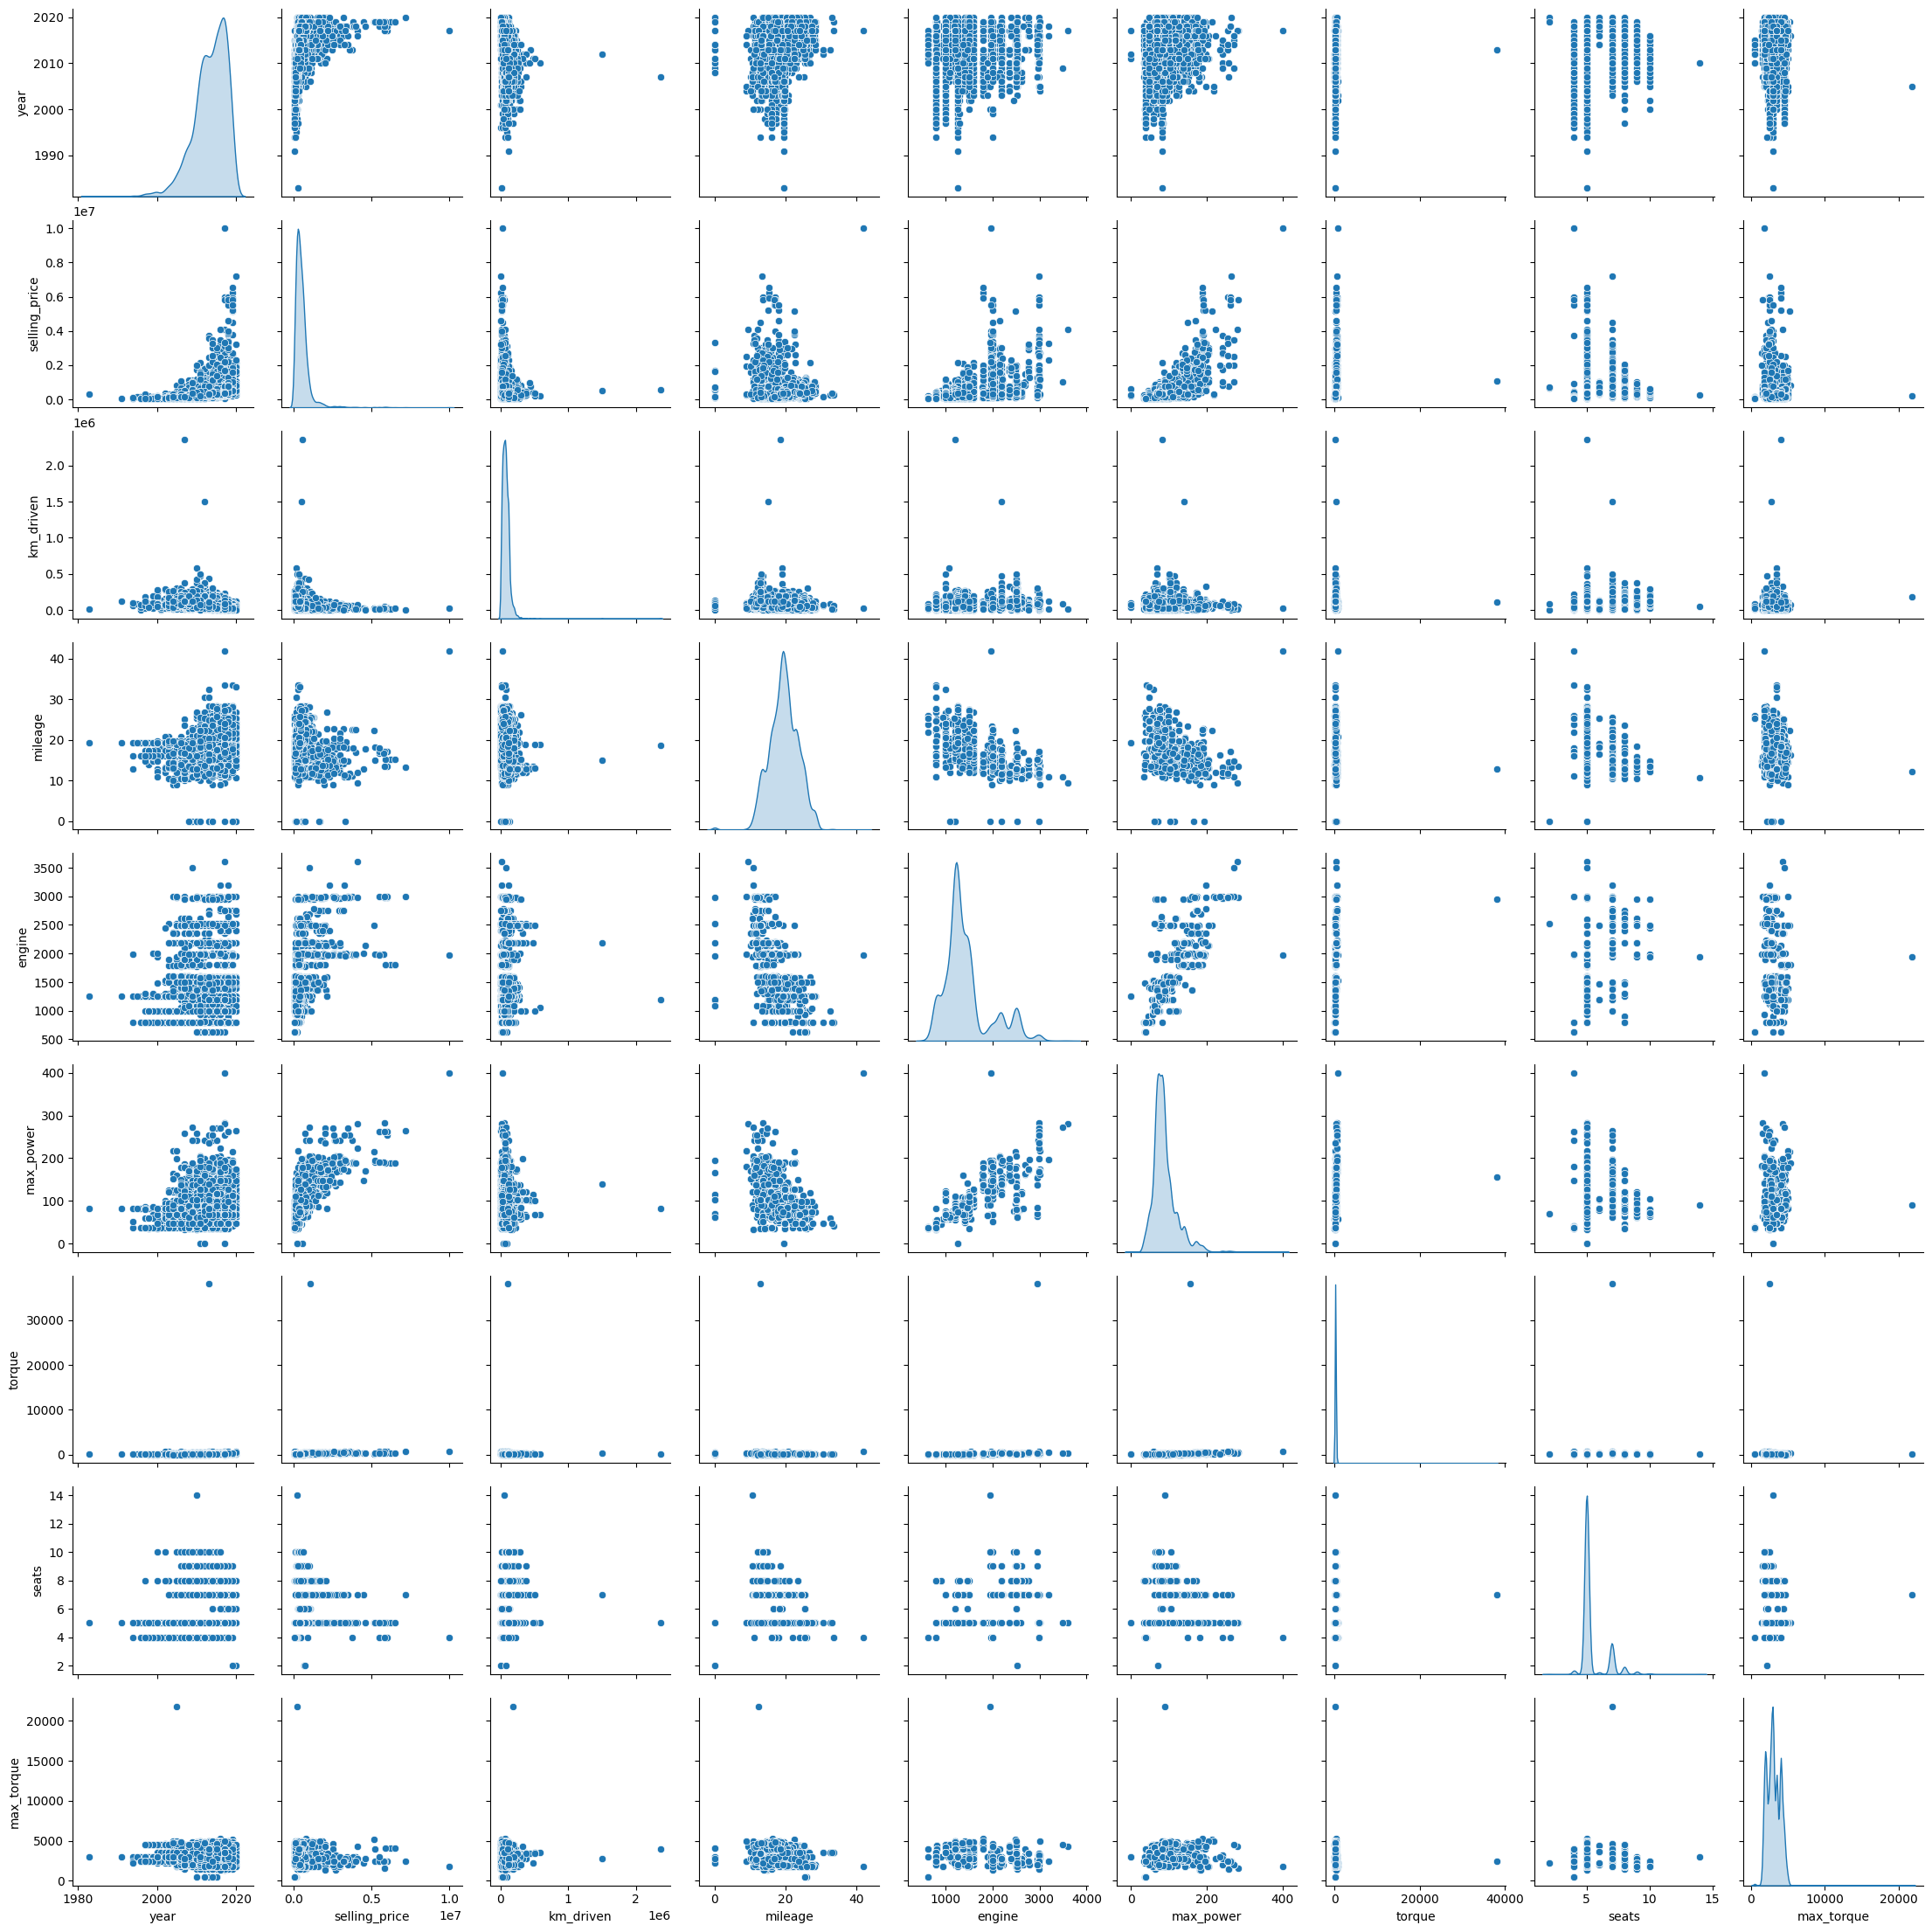

In [29]:
sns.pairplot(df_train, diag_kind='kde')#, hue='selling_price')
plt.show()

Этот график не такой информативный, как можно было бы построить, беря признаки по отдельности. Но он позволяет сделать некоторые (возможно, далеко идущие) выводы. Впрочем, со многими из них (если не со всеми) вы бы справились умозрительно. Однако всегда приятно делать выводы, основываясь на данных.



* <font color='#FF6600'> Что можно сказать о связи предикторов с целевой переменной?
    * Чем новее машина(больше year) - тем выше цена
    * Чем мощнее машина (больше engine, max_power, torque, max_torque) - тем выше цена
    * Чем меньше проехала (меньше km_driven) - тем меньше цена
    * Есть категории автобилей с небольшим количеством дверей - спортивные, седаны и у них цена выше чем у машин с болишим количеством дверей.
    
* А о корреляциях признаков? 
    * Чем больше двигатель тем мощнее автомобиль (с) Кэп
    * Чем больше год тем больше автомобиль проехал (с) Кэп
    * Автомобили с меньшим количеством дверей - мощнее (с) Кэп
    * Чем больше дверей у автомобиля - тем меньше они проезжаюь (либо меньше указаны в подборке)</font>

(0.25 балла) <font color='#9933CC'>Постройте pairplot по тестовым данным</font> и ответьте на вопрос <font color='#FF6600'>"Похожими ли оказались совокупности при разделении на трейн и тест?"</font>

/home/roman/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


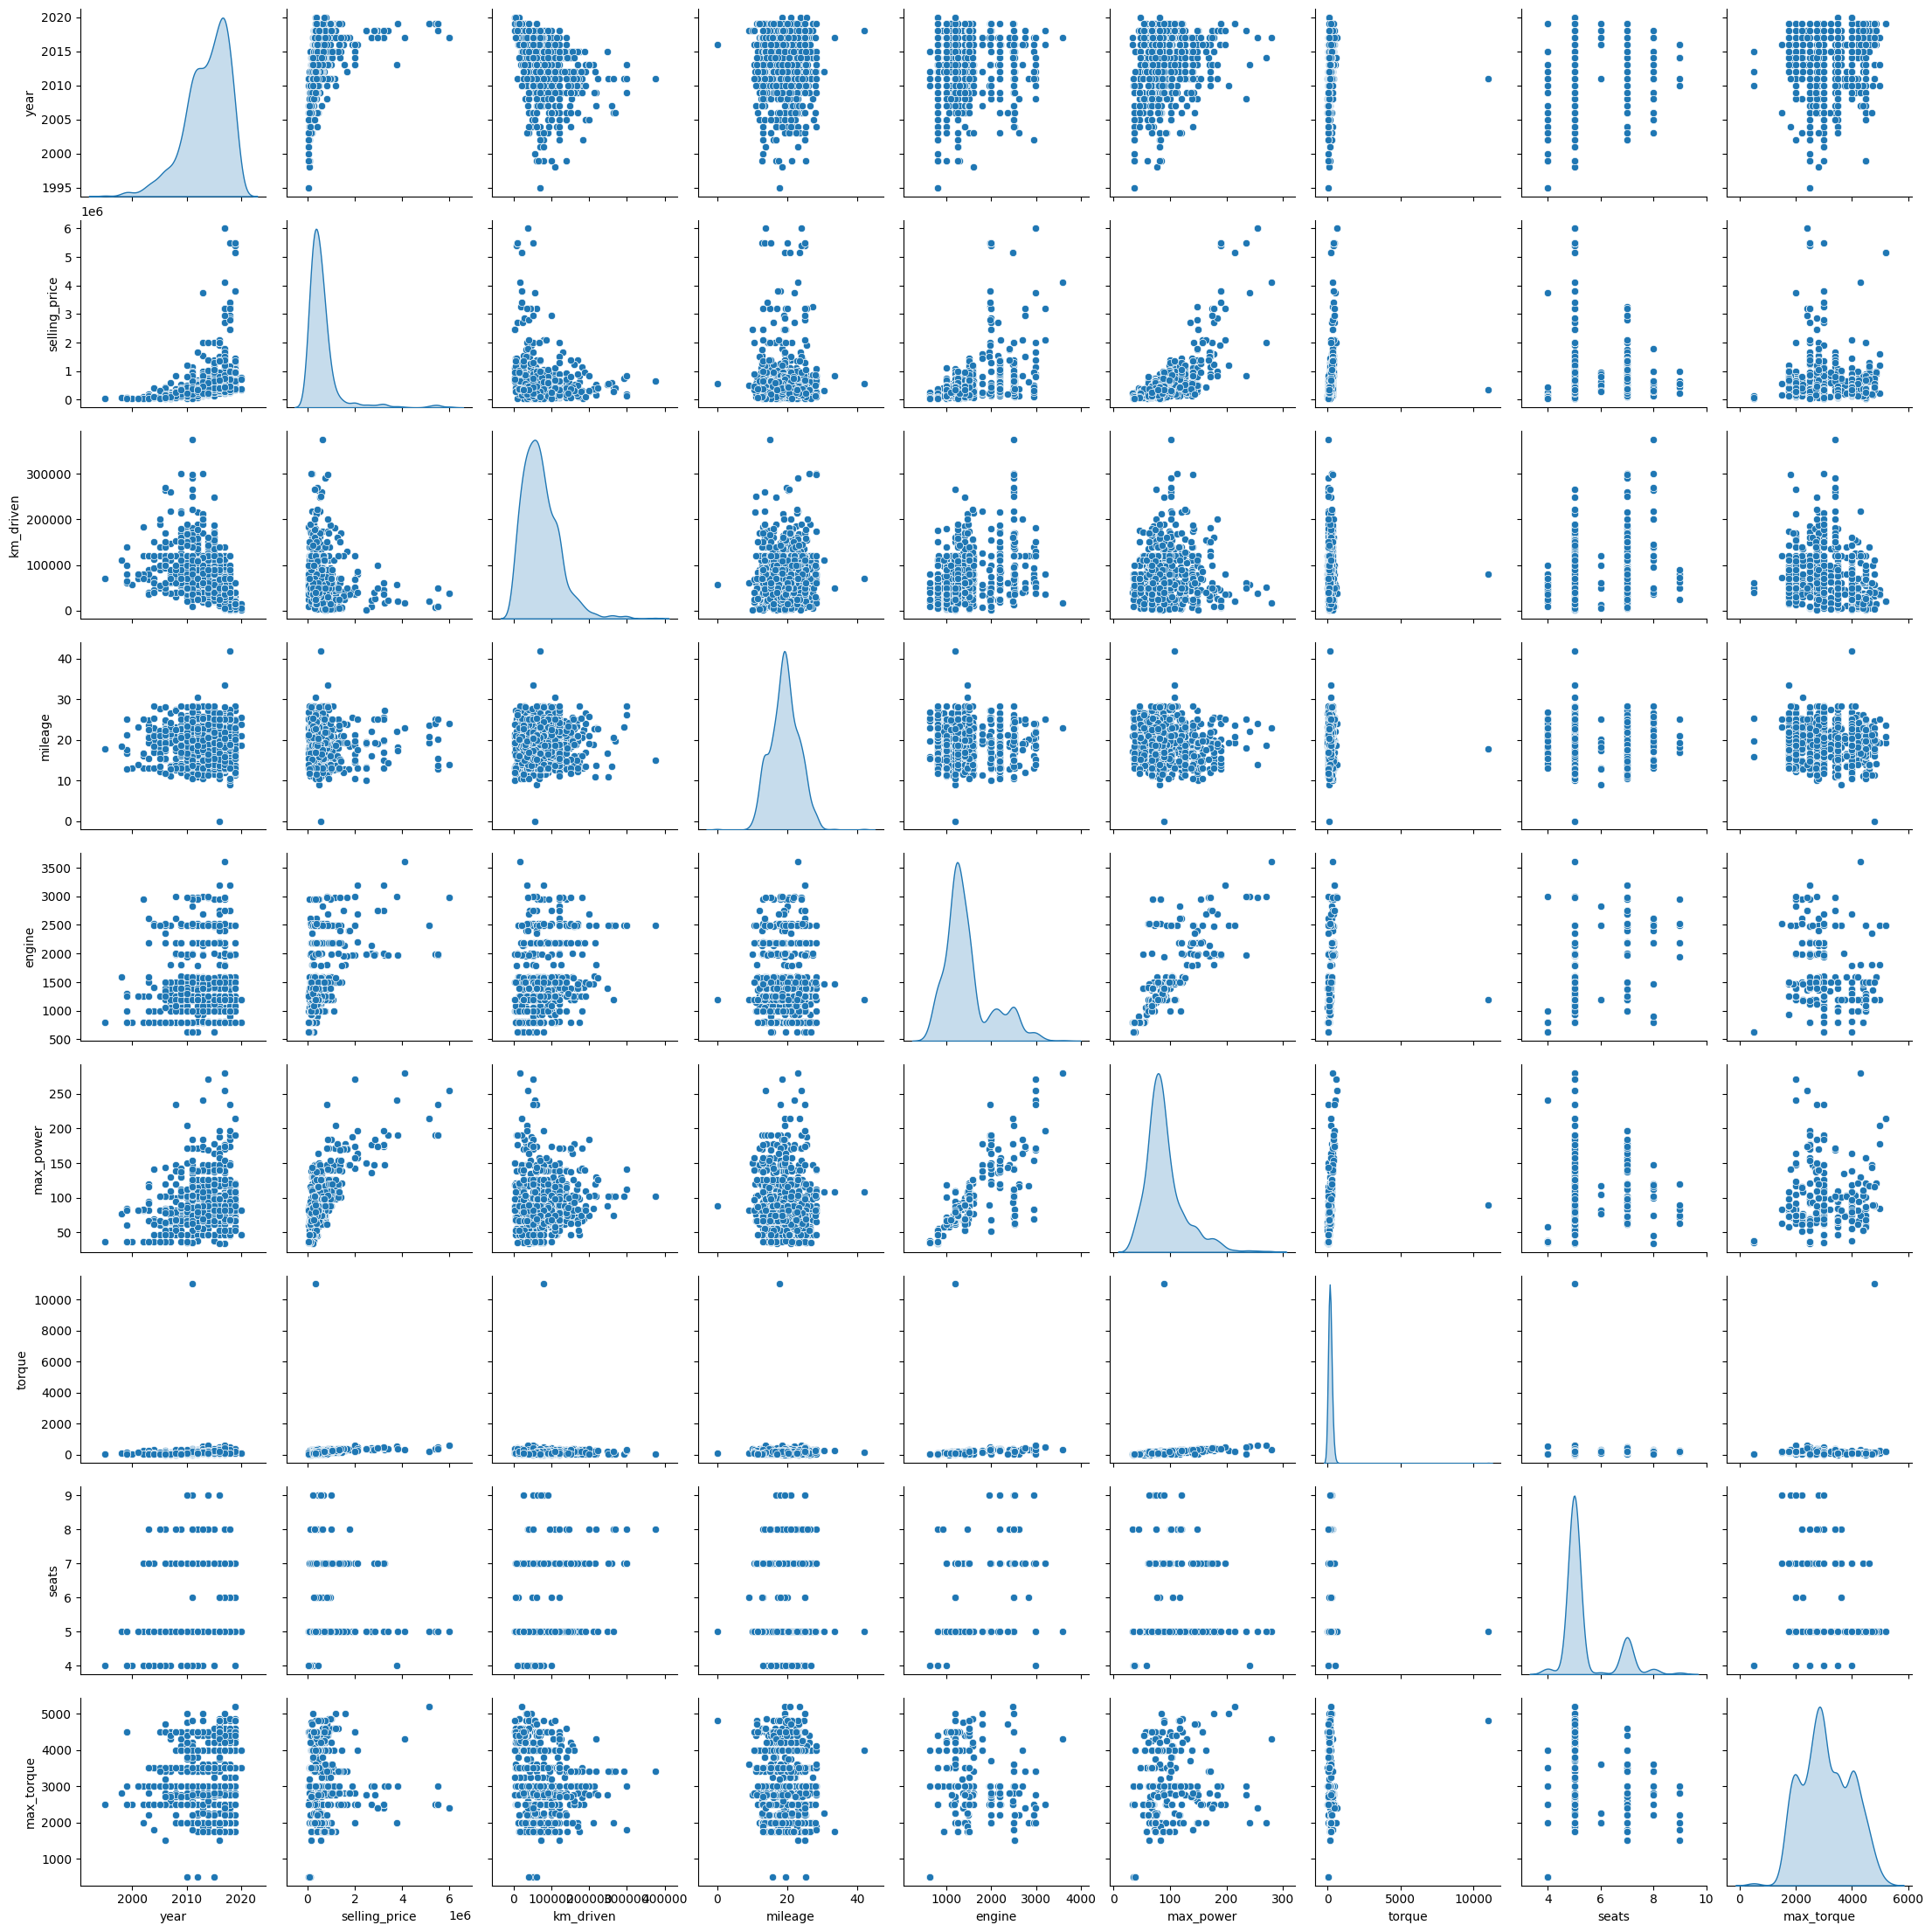

In [30]:
sns.pairplot(df_test, diag_kind='kde')#, hue='selling_price')
plt.show()

(0.25 балла) <font color='#9933CC'>Для трейна давайте построим тепловую карту (heatmap из библиотеки seaborn) попарных корреляций числовых колонок</font>

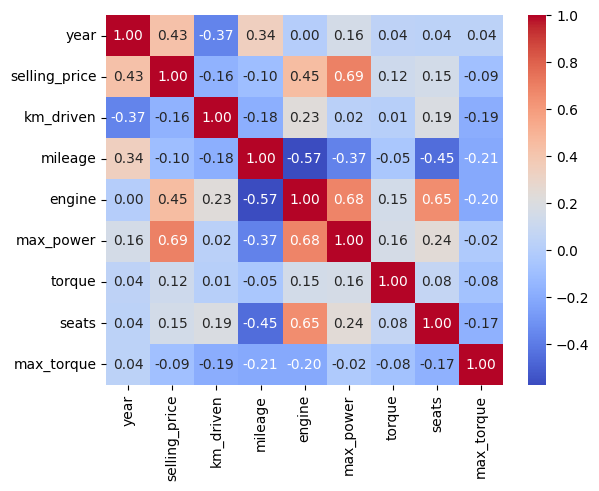

In [31]:
numerical_columns_train = df_train.select_dtypes(include=["number"])

correlation_matrix = numerical_columns_train.corr()

# Строим тепловую карту для матрицы корреляции
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Показываем график
plt.show()

Ответьте, пожалуйста, на вопросы: 
* <font color='#FF6600'>Какие 2 признака наименее скоррелированы между собой?</font>
    * Engine and mileage
* <font color='#FF6600'>Между какими наблюдается довольно сильная положительная линейная зависимость?</font>
    * Целевой переменной и max_power
* <font color='#FF6600'>Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи.</font>
    * Значение корреляции в 0,34 между этими признаками не позволяет нам это утверждать

(0.25 балла) <font color='#9933CC'> Отобразите диаграммe рассеяния для наиболее скореллированной пары **признаков** (на трейне) </font>

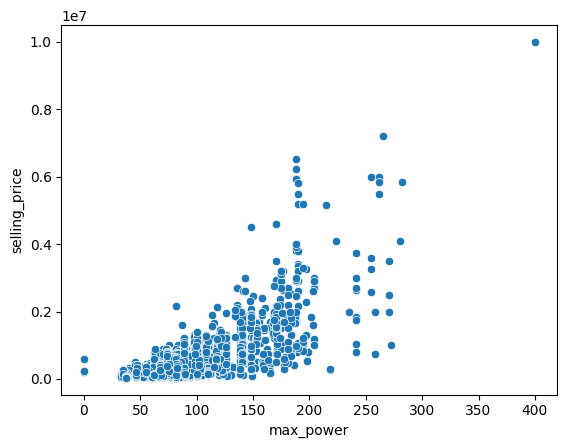

In [32]:
sns.scatterplot(x='max_power', y='selling_price', data=df_train)
plt.show()

### Дополнительные визуализации (бонус 0.5 балла)

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

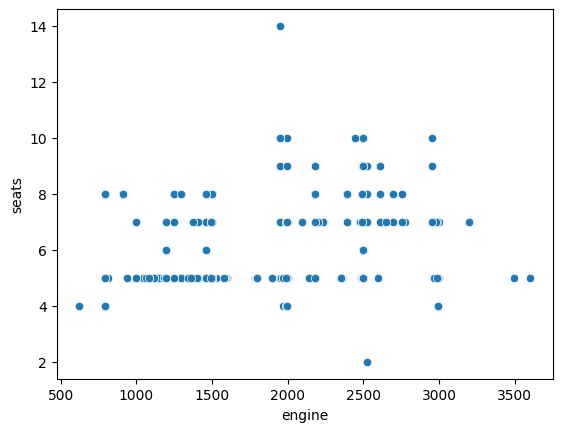

In [33]:
# Просто посмотрим, что у нас есть в выборке - как видно Ламборджини не так много
sns.scatterplot(x='engine', y='seats', data=df_train)
plt.show()

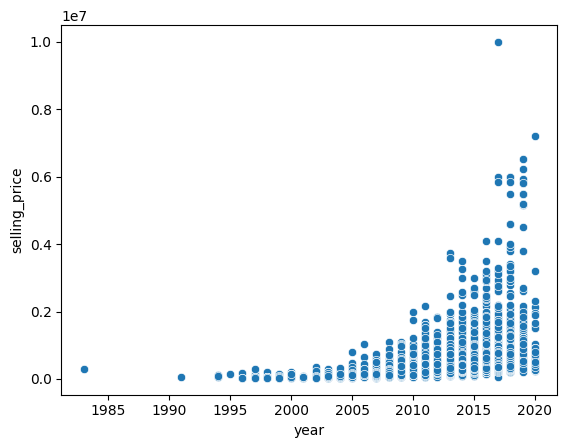

In [34]:
# Хоть корреляция и не самая сильная, но еще раз убеждаемся, что чем меньше год - тем больше цена
# ну и раритетные машины в выборке отсуствуют
sns.scatterplot(x='year', y='selling_price', data=df_train)
plt.show()

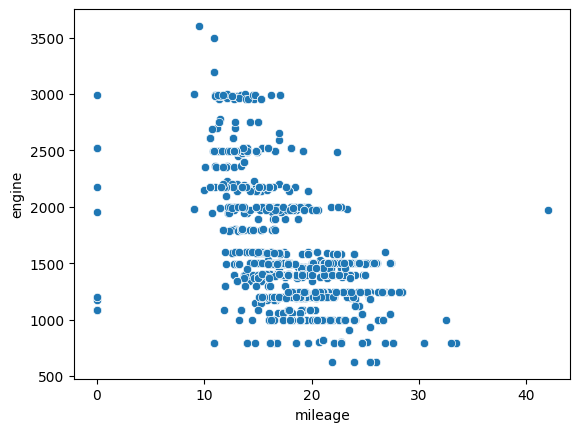

In [35]:
# Чем мощнее автомобиль, тем меньше на нем ездят
sns.scatterplot(x='mileage', y='engine', data=df_train)
plt.show()

# Часть 2 (1.25 балла) | Модель только на вещественных признаках

(0.05 балла) <font color='#9933CC'>В переменные ``y_train`` и ``y_test`` запишите значения целевых переменных. Столбцы ``selling_price`` из датафреймов необходимо удалить. Категориальные (все, кроме ``seats``) столбцы тоже.</font>

In [36]:
y_train = df_train['selling_price'].copy()
X_train = df_train.select_dtypes(include=["number"]).drop(['selling_price'], axis = 1).copy()

In [37]:
assert X_train.shape == (5840, 8) # +2 added max_torque

In [38]:
y_test = df_test['selling_price'].copy()
X_test = df_test.select_dtypes(include=["number"]).drop(['selling_price'], axis = 1).copy()

In [39]:
assert X_test.shape == (1000, 8)

(0.2 балла) <font color='#9933CC'>Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и MSE для трейна и для теста</font>

**Замечание:** $R^2$ и MSE для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

P.S. ниже, после стандартизации

Запомните правило:

> Использую линейную модель -- стандартизирую фичи

(0.25 балла) <font color='#9933CC'>Воспользуемся им</font>


In [40]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()  
# train scaler on train data
scaler.fit(X_train)

Xtrain_scaled = scaler.transform(X_train)
# as the result we have numpy array so conversion 2 pd is required
Xtrain_scaled = pd.DataFrame(Xtrain_scaled, columns=X_train.columns)  
# or just write Xtrain_scaled = scaler.fit_transform(Xtrain)

Xtest_scaled = scaler.transform(X_test)
Xtest_scaled = pd.DataFrame(Xtest_scaled, columns=X_test.columns)

In [41]:
linreg = LinearRegression()
linreg.fit(Xtrain_scaled, y_train)

linregAndEda = LinregAndEda()

print("Model metrics for train")
linregAndEda.show_metrics(linreg, Xtrain_scaled, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(linreg, Xtest_scaled, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._base.LinearRegression'>: 0.5999959610633816
MSE score for <class 'sklearn.linear_model._base.LinearRegression'>: 114656493057.23566
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._base.LinearRegression'>: 0.5987539705798692
MSE score for <class 'sklearn.linear_model._base.LinearRegression'>: 230647675547.2345


Не очень результативно.

Зато уже сейчас можем интерпретировать модель. <font color='#FF6600'>"Какой признак оказался наиболее информативным в предсказании цены?"</font>

> Max_power имеет наибольший абсолютный показатель. max_power = 328998.226903

In [42]:
features = Xtrain_scaled.columns
weights = linreg.coef_
feature_weights = pd.DataFrame({'Feature': features, 'Weight': weights})
feature_weights.sort_values(by='Weight', ascending=False)

,Feature,Weight
4,max_power,328998.226903
0,year,164453.085020
3,engine,31373.743713
5,torque,-274.152691
2,mileage,-5314.797831
6,seats,-29882.028301
1,km_driven,-48446.632226
7,max_torque,-55498.662142


(0.25 балла) <font color='#9933CC'>Теперь попробуем Lasso-регрессию.</font> Здесь и дальше обучайте модели на нормализованных признаках

In [43]:
from sklearn.linear_model import Lasso

model_l1 = Lasso()

model_l1.fit(Xtrain_scaled, y_train)

Lasso()

In [44]:
print("Model metrics for train")
linregAndEda.show_metrics(model_l1, Xtrain_scaled, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(model_l1, Xtest_scaled, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._coordinate_descent.Lasso'>: 0.599995961010811
MSE score for <class 'sklearn.linear_model._coordinate_descent.Lasso'>: 114656493072.30441
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._coordinate_descent.Lasso'>: 0.5987531765629472
MSE score for <class 'sklearn.linear_model._coordinate_descent.Lasso'>: 230648131970.83496


<font color='#FF6600'>Занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Почему же?</font>

> Мы не установили силу регуляризации и значение по умолчанию оказалось слабым для этого

In [45]:
model_l1.coef_

array([ 1.64450897e+05, -4.84456896e+04, -5.31160035e+03,  3.13713201e+04,
        3.28999267e+05, -2.72865986e+02, -2.98780674e+04, -5.54964239e+04])

(0.25 балла) <font color='#9933CC'>Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии</font>

Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


lasso_model = Lasso()

alphas = np.logspace(0, 8, 1000)  # 1000 точек от 1 до 10^8

param_grid = {'alpha': alphas}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(lasso_model, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(Xtrain_scaled, y_train)

print("Оптимальное значение alpha:", grid_search.best_params_)

Оптимальное значение alpha: {'alpha': 3528.154115380883}


<font color='#FF6600'>Сколько грид-сёрчу пришлось обучать моделей?</font>

> 1000 значений альфа, 10 фолдов -> 10000 моделей

<font color='#FF6600'>Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?</font>

> да - mileage	and torque

In [47]:
model_l1 = Lasso(alpha=3528.15)

model_l1.fit(Xtrain_scaled, y_train)

print("Model metrics for train")
linregAndEda.show_metrics(model_l1, Xtrain_scaled, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(model_l1, Xtest_scaled, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._coordinate_descent.Lasso'>: 0.5995600786461983
MSE score for <class 'sklearn.linear_model._coordinate_descent.Lasso'>: 114781433669.01648
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._coordinate_descent.Lasso'>: 0.5948775096470034
MSE score for <class 'sklearn.linear_model._coordinate_descent.Lasso'>: 232875975986.2627


In [48]:
features = Xtrain_scaled.columns
weights = model_l1.coef_
feature_weights = pd.DataFrame({'Feature': features, 'Weight': weights})
feature_weights.sort_values(by='Weight', ascending=False)

,Feature,Weight
4,max_power,332581.395851
0,year,159136.699383
3,engine,20568.397706
2,mileage,-0.000000
5,torque,0.000000
6,seats,-17308.158668
1,km_driven,-44903.133601
7,max_torque,-49929.628316


(0.25 балла) <font color='#9933CC'>Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)-регрессии</font>

In [49]:
from sklearn.linear_model import ElasticNet

elastic_net_model = ElasticNet()

parameters = {'alpha': np.logspace(0, 8, 50), 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(elastic_net_model, parameters, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(Xtrain_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e+00, 1.45634848e+00, 2.12095089e+00, 3.08884360e+00,
       4.49843267e+00, 6.55128557e+00, 9.54095476e+00, 1.38949549e+01,
       2.02358965e+01, 2.94705170e+01, 4.29193426e+01, 6.25055193e+01,
       9.10298178e+01, 1.32571137e+02, 1.93069773e+02, 2...
       3.72759372e+04, 5.42867544e+04, 7.90604321e+04, 1.15139540e+05,
       1.67683294e+05, 2.44205309e+05, 3.55648031e+05, 5.17947468e+05,
       7.54312006e+05, 1.09854114e+06, 1.59985872e+06, 2.32995181e+06,
       3.39322177e+06, 4.94171336e+06, 7.19685673e+06, 1.04811313e+07,
       1.52641797e+07, 2.22299648e+07, 3.23745754e+07, 4.71486636e+07,
       6.86648845e+07, 1.00000000e+08]),
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]},
             scoring='neg_mean_squared_error')

<font color='#FF6600'>Какие гиперпараметры соответствуют лучшей из перебранных моделей?</font>

In [50]:
print("Оптимальные параметры:", grid_search.best_params_)

Оптимальные параметры: {'alpha': 3906.939937054613, 'l1_ratio': 1}


In [51]:
elastic_net_model = ElasticNet(alpha=3906.94, l1_ratio = 1)

elastic_net_model.fit(Xtrain_scaled, y_train)

ElasticNet(alpha=3906.94, l1_ratio=1)

In [52]:
print("Model metrics for train")
linregAndEda.show_metrics(elastic_net_model, Xtrain_scaled, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(elastic_net_model, Xtest_scaled, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>: 0.5994704768125683
MSE score for <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>: 114807116989.72205
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>: 0.5943672784651335
MSE score for <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>: 233169271439.57858


Предлагаем вам оставить вам попытки заметно улучшить качество модели регуляризацией и перейти к следующей части задания.

# Часть 3 (0.5 балла) | Добавляем категориальные фичи



(0 баллов) <font color='#9933CC'>Из ``df_train`` удалите столбцы с целевой переменной и названием автомобиля.</font>

In [53]:
X_train_cat = df_train.drop(['selling_price', 'name'], axis=1).copy()
X_test_cat = df_test.drop(['selling_price', 'name'], axis=1).copy()

In [54]:
assert X_train_cat.shape == (5840, 12) # +2

In [55]:
X_train_cat.describe(include='object')

,fuel,seller_type,transmission,owner
count,5840,5840,5840,5840
unique,4,3,2,5
top,Diesel,Individual,Manual,First Owner
freq,3177,5223,5336,3603


(0.5 балла) <font color='#9933CC'>Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования</font>

> Обратите внимание, что во избежание мультиколлинеарности следует избавиться от одного из полученных столбцов при кодировании каждого признака методом OneHot. 

In [56]:
# Эта часть нужна для того чтобы в трейне и тесте было одинаковое количетво столбцов
# *в трейне просто меньше данных, тут мы читерим, так как уже обожглись на колонке seats
unique_train_values = X_train_cat['seats'].unique()
unique_test_values = X_test_cat['seats'].unique()

all_unique_values = set(unique_train_values) | set(unique_test_values)

all_unique_values

{2, 4, 5, 6, 7, 8, 9, 10, 14}

In [57]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas

X_train_cat = pd.get_dummies(X_train_cat, drop_first=True, columns=['seats'])
X_train_cat = pd.get_dummies(X_train_cat, drop_first=True, columns=['fuel'])
X_train_cat = pd.get_dummies(X_train_cat, drop_first=True, columns=['seller_type'])
X_train_cat = pd.get_dummies(X_train_cat, drop_first=True, columns=['transmission'])
X_train_cat = pd.get_dummies(X_train_cat, drop_first=True, columns=['owner'])

In [58]:
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True, columns=['seats'])
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True, columns=['fuel'])
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True, columns=['seller_type'])
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True, columns=['transmission'])
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True, columns=['owner'])


In [59]:
missing_cols = set(X_train_cat.columns) - set(X_test_cat.columns)
for col in missing_cols:
    X_test_cat[col] = False

In [60]:
X_train_cat = X_train_cat.sort_index(axis=1)
X_test_cat = X_test_cat.sort_index(axis=1)

In [61]:
scaler.fit(X_train_cat)

X_train_cat_scaled = scaler.transform(X_train_cat)
X_train_cat_scaled = pd.DataFrame(X_train_cat_scaled, columns=X_test_cat.columns)  


X_test_cat_scaled = scaler.transform(X_test_cat)
X_test_cat_scaled = pd.DataFrame(X_test_cat_scaled, columns=X_train_cat.columns)

(0.25 балла) <font color='#9933CC'>Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV`.</font> В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.

<font color='#FF6600'>Удалось ли улучшить качество предсказаний?</font>

> Вроде как да, но у MSE все еще безумное значение в 95452110270.66649 на трейне и 221298291038.85986 на тесте.

In [62]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

ridge_model = Ridge()

alphas = np.logspace(0, 8, 200)  
#print(alphas)

scorer = make_scorer(r2_score)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search_ridge = GridSearchCV(ridge_model, {'alpha': alphas}, cv=cv, scoring=scorer)

grid_search_ridge.fit(X_train_cat_scaled, y_train)

print("Оптимальное значение alpha для L2:", grid_search_ridge.best_params_)

Оптимальное значение alpha для L2: {'alpha': 541.5871378079471}


In [63]:
ridge_model = Ridge(alpha=541.59)
ridge_model.fit(X_train_cat_scaled, y_train)

Ridge(alpha=541.59)

In [64]:
print("Model metrics for train")
linregAndEda.show_metrics(ridge_model, X_train_cat_scaled, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(ridge_model, X_test_cat_scaled, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.6669946148254309
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 95452110270.66649
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.6150186192593187
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 221298291038.85986


# Часть 4 - бонусная (1.5 балла) | Feature Engineering 

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [65]:
# 1 пойдем в лоб и добавим полинональные признаки 2 степени
from sklearn.preprocessing import PolynomialFeatures  

pf = PolynomialFeatures(degree = 2)

pf.fit(X_train_cat)

Xtrain_pol = pf.transform(X_train_cat)
Xtest_pol = pf.transform(X_test_cat)

In [66]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(Xtrain_pol, y_train)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.8584e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=1)

In [67]:
print("Model metrics for train")
linregAndEda.show_metrics(ridge_model, Xtrain_pol, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(ridge_model, Xtest_pol, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.8769019444263202
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 35284622104.72637
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: -77.96376056712623
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 45390624434581.12


> Видим, что модель переобучилась, давайте подберем альфу

In [68]:
ridge_model = Ridge()

alphas = np.logspace(0, 8, 200) 

scorer = make_scorer(r2_score)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search_ridge = GridSearchCV(ridge_model, {'alpha': alphas}, cv=cv, scoring=scorer)

grid_search_ridge.fit(Xtrain_pol, y_train)

print("Оптимальное значение alpha для L2:", grid_search_ridge.best_params_)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.03801e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.14952e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.8694e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.93109e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/roman/.local/lib/python3.10/site-packages/sklearn/l

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.3238e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.24419e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.24049e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.24228e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/roman/.local/lib/python3.10/site-packages/sklearn/l

Оптимальное значение alpha для L2: {'alpha': 20022.003718155844}


/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.37223e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.35719e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.85261e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


> Оптимальное значение alpha для L2: {'alpha': 20022.003718155844}

In [69]:
ridge_model = Ridge(alpha=20022)
ridge_model.fit(Xtrain_pol, y_train)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.85261e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=20022)

In [70]:
print("Model metrics for train")
linregAndEda.show_metrics(ridge_model, Xtrain_pol, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(ridge_model, Xtest_pol, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.8375831219080202
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 46554904057.56051
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.45722067624158313
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 312005054706.46234


> Немного избавились от переобучения, но результаты на тесте не очень

In [71]:
# 2 Давайте поробуем добавить новые признаки, к примеру квадрат года

Xtrain_newfeatures = X_train_cat.copy()
Xtest_newfeatures = X_test_cat.copy()

Xtrain_newfeatures["year_square"] = Xtrain_newfeatures["year"] ** 2
Xtest_newfeatures["year_square"] = Xtest_newfeatures["year"] ** 2

In [72]:
scaler.fit(Xtrain_newfeatures)

Xtrain_newfeatures_scaled = scaler.transform(Xtrain_newfeatures)
Xtrain_newfeatures_scaled = pd.DataFrame(Xtrain_newfeatures_scaled, columns=Xtrain_newfeatures.columns)  


Xtest_newfeatures_scaled = scaler.transform(Xtest_newfeatures)
Xtest_newfeatures_scaled = pd.DataFrame(Xtest_newfeatures_scaled, columns=Xtest_newfeatures.columns)

In [73]:
ridge_model = Ridge()

alphas = np.logspace(0, 8, 200) 

scorer = make_scorer(r2_score)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search_ridge = GridSearchCV(ridge_model, {'alpha': alphas}, cv=cv, scoring=scorer)

grid_search_ridge.fit(Xtrain_newfeatures_scaled, y_train)

print("Оптимальное значение alpha для L2:", grid_search_ridge.best_params_)

Оптимальное значение alpha для L2: {'alpha': 594.1133984965034}


In [74]:
ridge_model = Ridge(alpha=594.11)
ridge_model.fit(Xtrain_newfeatures_scaled, y_train)

Ridge(alpha=594.11)

In [75]:
print("Model metrics for train")
linregAndEda.show_metrics(ridge_model, Xtrain_newfeatures_scaled, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(ridge_model, Xtest_newfeatures_scaled, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.6668359758762006
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 95497582275.47272
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.6136287299950143
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 222097239077.15738


> ок, давайте попробуем другие модели

In [76]:
parameters = {'alpha': np.logspace(0, 8, 50), 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(elastic_net_model, parameters, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(Xtrain_newfeatures_scaled, y_train)

print("Оптимальные параметры:", grid_search.best_params_)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.479e+14, tolerance: 1.546e+11
  model = cd_fast.enet_coordinate_descent(
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.342e+14, tolerance: 1.474e+11
  model = cd_fast.enet_coordinate_descent(
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.41

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.499e+14, tolerance: 1.520e+11
  model = cd_fast.enet_coordinate_descent(
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e+14, tolerance: 1.452e+11
  model = cd_fast.enet_coordinate_descent(
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.31

Оптимальные параметры: {'alpha': 2682.6957952797247, 'l1_ratio': 1}


In [77]:
elastic_net_model = ElasticNet(alpha=2682.69, l1_ratio = 1)

elastic_net_model.fit(Xtrain_newfeatures_scaled, y_train)

ElasticNet(alpha=2682.69, l1_ratio=1)

In [78]:
print("Model metrics for train")
linregAndEda.show_metrics(elastic_net_model, Xtrain_newfeatures_scaled, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(elastic_net_model, Xtest_newfeatures_scaled, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>: 0.6703794809492754
MSE score for <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>: 94481877869.36382
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>: 0.6248200826483021
MSE score for <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>: 215664129995.82736


> чуть лучше чем прошлая, давайте добавим еще признаков

In [79]:
# 3. добавляем марку автомобиля
brand_train = df_train['name'].apply(lambda x: str(x).split(' ')[0])
brand_test = df_test['name'].apply(lambda x: str(x).split(' ')[0])

In [80]:
# кодируем
brand_train = pd.get_dummies(brand_train, drop_first=True, columns=['brand'])
brand_test = pd.get_dummies(brand_test, drop_first=True, columns=['brand'])

# в тесте и трейне разные марки, а значит разные колонки
missing_cols = set(brand_train.columns) - set(brand_test.columns)
for col in missing_cols:
    brand_test[col] = False

missing_cols = set(brand_test.columns) - set(brand_train.columns)
for col in missing_cols:
    brand_train[col] = False


# сортируем
brand_train = brand_train.sort_index(axis=1)
brand_test = brand_test.sort_index(axis=1)

In [81]:
# У нас безумные значения MSE - давайте попробуем поработаться с выбросами
def drop_outliers(df, threshold=1.5):
    """
    Удаляет строки с выбросами в числовых колонках датафрейма.

    Параметры:
    - df: pandas DataFrame
    - threshold: Порог для определения выбросов (по умолчанию 1.5)
    """
    numeric_columns = df.select_dtypes(include=np.number).columns  # Выбираем числовые колонки
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Удаление строк с выбросами
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
    return df

In [82]:
# Начинаем собирать финальный набор признаков
Xtrain_final = pd.concat([Xtrain_newfeatures, brand_train], axis=1)
Xtest_final = pd.concat([Xtest_newfeatures, brand_test], axis=1)

In [83]:
# Избавляемся от выбросов

# Для начала склеиваем с целевой переменной, чтобы потом со спокойной душой убрать выбросы

Xtrain_final = pd.concat([Xtrain_final, y_train], axis=1)
Xtest_final = pd.concat([Xtest_final, y_test], axis=1)

Xtrain_final = drop_outliers(Xtrain_final, threshold=1.2)
Xtest_final = drop_outliers(Xtest_final, threshold=1.2)

y_train = Xtrain_final['selling_price']
y_test = Xtest_final['selling_price']

Xtrain_final.drop(['selling_price'], inplace=True, axis=1)
Xtest_final.drop(['selling_price'], inplace=True, axis =1)

In [84]:
Xtrain_final

,engine,fuel_Diesel,fuel_LPG,fuel_Petrol,km_driven,max_power,max_torque,mileage,owner_Fourth & Above Owner,owner_Second Owner,...,Mitsubishi,Nissan,Opel,Peugeot,Renault,Skoda,Tata,Toyota,Volkswagen,Volvo
0,1248,True,False,False,145500,74.00,2000.0,23.40,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1498,True,False,False,120000,103.52,2500.0,21.14,False,True,...,False,False,False,False,False,True,False,False,False,False
2,1396,True,False,False,127000,90.00,3000.0,23.00,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1298,False,False,True,120000,88.20,4500.0,16.10,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1197,False,False,True,45000,81.86,4000.0,20.14,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5834,998,False,False,True,80000,67.04,3500.0,20.51,False,False,...,False,False,False,False,False,False,False,False,False,False
5836,998,False,False,True,50000,67.10,3500.0,18.90,False,True,...,False,False,False,False,False,False,False,False,False,False
5837,1197,False,False,True,110000,82.85,4000.0,18.50,False,False,...,False,False,False,False,False,False,False,False,False,False
5838,1493,True,False,False,119000,110.00,2750.0,16.80,True,False,...,False,False,False,False,False,False,False,False,False,False


In [85]:
# 4. чтобы два раза не ходить давайте логарифмируем пробег.
# по натуральному логарифму потому что почему бы и нет
Xtrain_final['mileage'] = Xtrain_final['mileage'].apply(lambda x: 0 if x<1 else np.log(x))
Xtest_final['mileage'] = Xtest_final['mileage'].apply(lambda x:  0 if x<1 else np.log(x))

In [86]:
# Сортируем
Xtrain_final = Xtrain_final.sort_index(axis=1)
Xtest_final = Xtest_final.sort_index(axis=1)

In [87]:
Xtrain_final.loc[0].to_csv('row_data.csv', index=True)

In [88]:
# нормализуем

scaler.fit(Xtrain_final)

Xtrain_final_scaled = scaler.transform(Xtrain_final)
Xtrain_final_scaled = pd.DataFrame(Xtrain_final_scaled, columns=Xtrain_final.columns)  


Xtest_final_scaled = scaler.transform(Xtest_final)
Xtest_final_scaled = pd.DataFrame(Xtest_final_scaled, columns=Xtest_final.columns)

In [102]:
# сохраняем для сервиса
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [90]:
# Ищем альфу

ridge_model = Ridge()

alphas = np.logspace(0, 8, 200) 

scorer = make_scorer(r2_score)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search_ridge = GridSearchCV(ridge_model, {'alpha': alphas}, cv=cv, scoring=scorer)

grid_search_ridge.fit(Xtrain_final_scaled, y_train)

print("Оптимальное значение alpha для L2:", grid_search_ridge.best_params_)

Оптимальное значение alpha для L2: {'alpha': 1.0}


In [91]:
ridge_model_final = Ridge(alpha=1)
ridge_model_final.fit(Xtrain_final_scaled, y_train)

Ridge(alpha=1)

In [92]:
print("Model metrics for train")
linregAndEda.show_metrics(ridge_model_final, Xtrain_final_scaled, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(ridge_model_final, Xtest_final_scaled, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.7952295439419368
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 8875619660.111885
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.8117959884659254
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 8516275336.703616


> В целом, лучший результат из всех моделей, но если мы добавим сюда полиномиальные признаки..

In [93]:
# добаляем полиномиальные признаки
pf.fit(Xtrain_final_scaled)
Xtrain_final_scaled_norm = pf.transform(Xtrain_final_scaled)
Xtest_final_scaled_norm = pf.transform(Xtest_final_scaled)

In [94]:
ridge_model = Ridge()

alphas = np.logspace(0, 4, 100)

scorer = make_scorer(r2_score)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search_ridge = GridSearchCV(ridge_model, {'alpha': alphas}, cv=cv, scoring=scorer)

grid_search_ridge.fit(Xtrain_final_scaled_norm, y_train)

print("Оптимальное значение alpha для L2:", grid_search_ridge.best_params_)

Оптимальное значение alpha для L2: {'alpha': 114.97569953977369}


In [95]:
ridge_model_final_pol = Ridge(alpha = 114.976)
ridge_model_final_pol.fit(Xtrain_final_scaled_norm, y_train)

Ridge(alpha=114.976)

In [96]:
print("Model metrics for train")
linregAndEda.show_metrics(ridge_model_final_pol, Xtrain_final_scaled_norm, y_train)
print('----------------')
print("Model metrics for test")
linregAndEda.show_metrics(ridge_model_final_pol, Xtest_final_scaled_norm, y_test)

Model metrics for train
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.8770066513410673
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 5331053143.284895
----------------
Model metrics for test
R2 score for <class 'sklearn.linear_model._ridge.Ridge'>: 0.7378600390604939
MSE score for <class 'sklearn.linear_model._ridge.Ridge'>: 11861894259.93917


> То результат ухудшился. (Если бы мы не чистили от выбросов, то получили бы с этой моделью лучший результат) ¯\_(ツ)_/¯

In [97]:
# сохраняем модель в богопротивный pickle

with open('ridge_model_final.pkl', 'wb') as file:
    pickle.dump(ridge_model_final, file)

# Часть Бизнесовая (0.5 балла)

Заказчик просил вас посчитать кастомную метрику -- среди всех предсказанных цен на авто посчитать долю предиктов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

<font color='#9933CC'>Сделайте это самостоятельно для лучшей из своих моделей</font>

> 36.47

In [98]:
def business_metrics(y_true, y_pred):
   
    difference_percentage = np.abs((y_pred - y_true) / y_true) * 100
    accuracy = np.mean(difference_percentage < 10)

    return (f"{accuracy * 100:.2f}")

business_metrics(y_test, ridge_model_final.predict(Xtest_final_scaled))

'36.47'

# Часть 5 (2.5 балла) | Реализация сервиса на FastAPI

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [99]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str 
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return ...


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    return ...

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# Часть 6 (1 балл) | Оформление результатов

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете прислать screencast в ТГ
3. Просматривает ноутбук с pure-DS частью
4. Заглядывает в код сервиса
5. Хвалит

# Часть Благодарственная

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

https://drive.google.com/file/d/1LT06nyg9QgVi3r-D5BY-_mQ9TcJQFxJN/view?usp=share_link